**3D-Cube Orientation**

Class data structure and operations relate
to a Rubik's Cube as in this orientation:

![alt text](images/rubiks_web.png)
![alt text](images/rubiks-cube.jpg)

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt

from Opticube import Opticube
from VectorCube import color_name
from CubeView import CubeView
from FaceletSolver import FaceletSolver

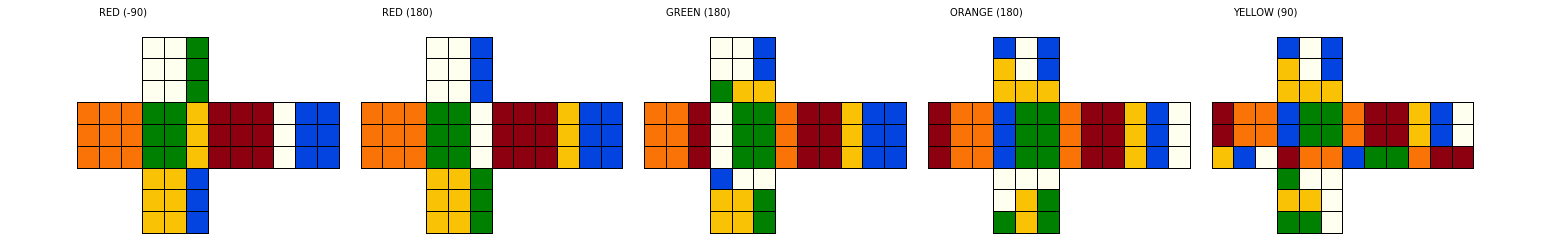

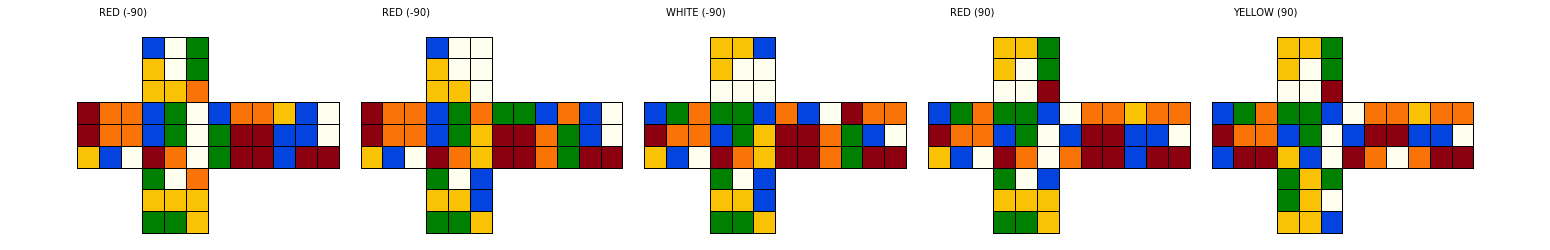

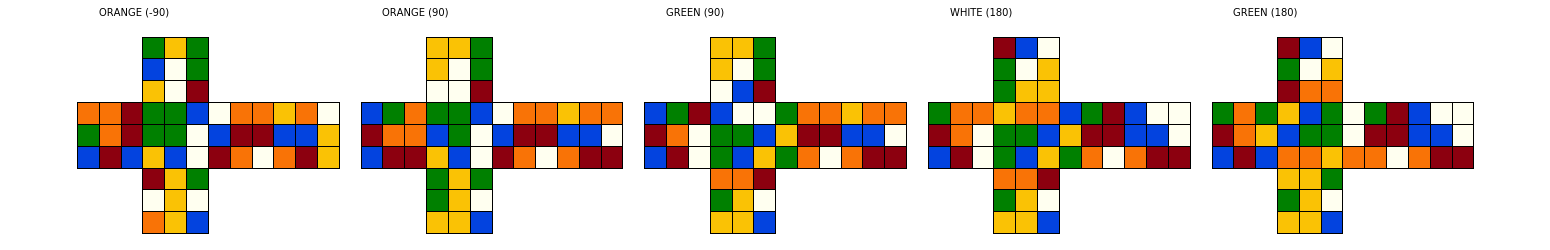

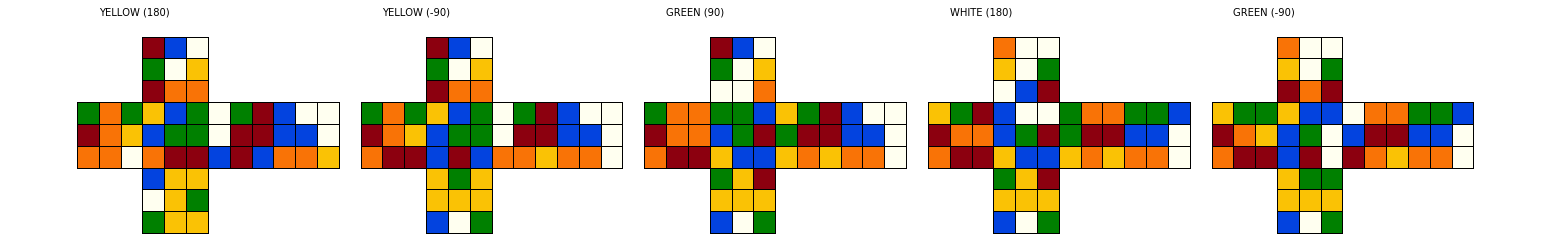

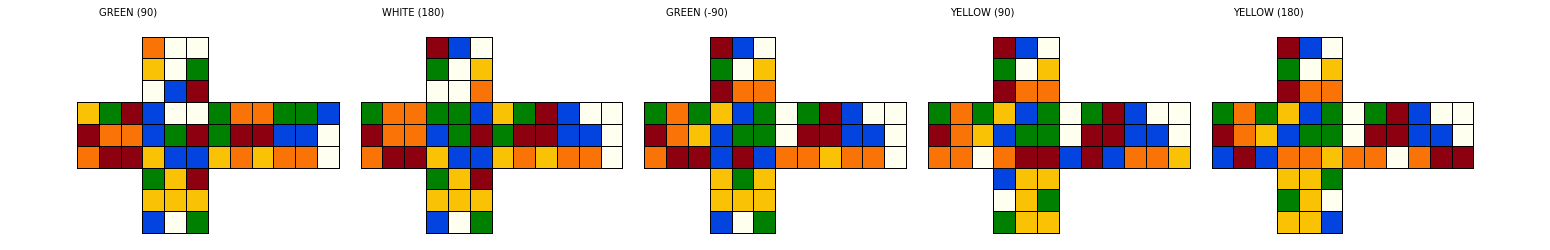

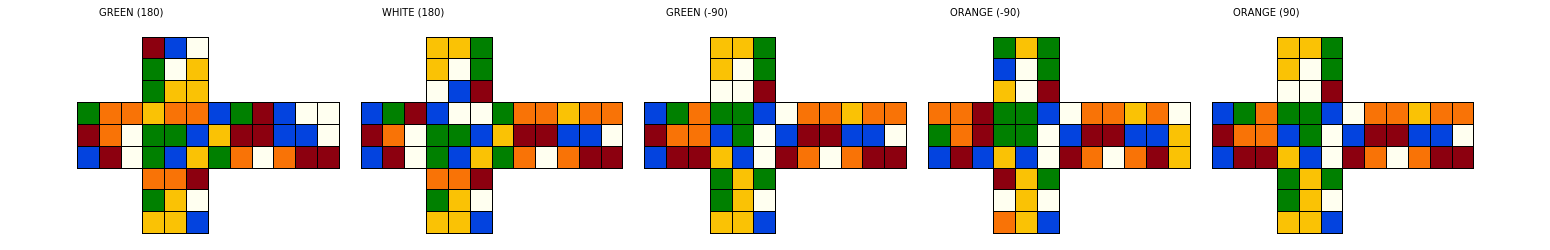

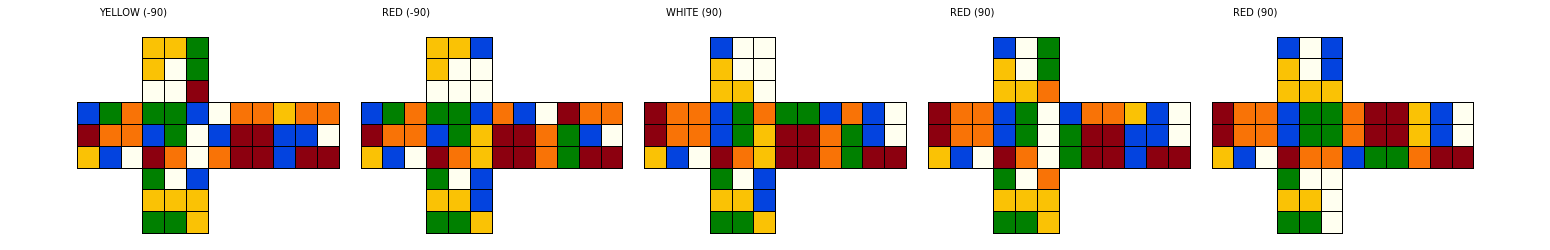

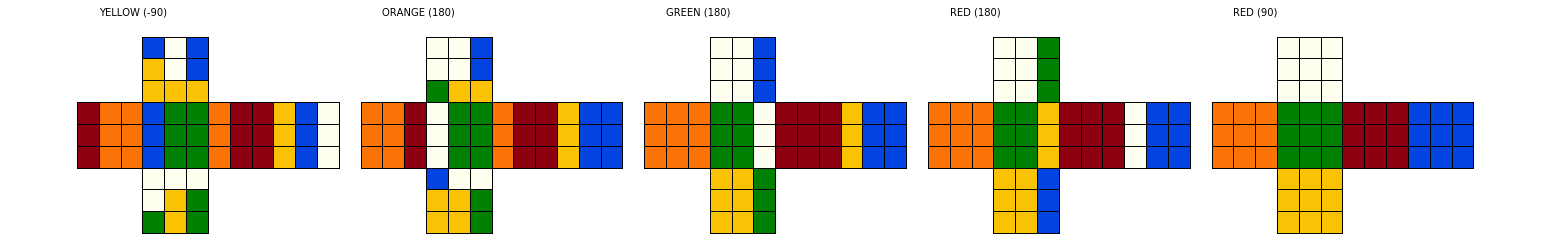

In [2]:
# Simple test of basic Opticube representation of a 
# Rubik's Cube (scrambling/rotating sides) with the 
# OpticubeView class to display cube image (projection)

cube = Opticube()
view = CubeView(cube)
moves, invmoves = cube.trace_scramble()

for mv in moves:
    cube.rotate(mv)
    view.push_snapshot(caption=f"{color_name(mv[0])} ({mv[1]})")
    
view.draw_snapshops()
view.reset_snapshots()

for inv in invmoves:
    cube.rotate(inv)
    view.push_snapshot(caption=f"{color_name(inv[0])} ({inv[1]})")
    
view.draw_snapshops()

In [3]:
###### Create sequence_hash and verify it with a print #######
fsolver = FaceletSolver()
sequences = fsolver.create_sequence_hash(wildcard=True)
heuristic_hash = fsolver.create_heuristic_hash(sequences)
# fsolver.print_sequence_hash(sequences, exclusive=False)

##### Tests the FaceletSolver solution calculations #####
# Prints the 48 facelet solution paths from sequence_hash,
# executes a single random move, then prints altered paths

print("Solved heuristic:", fsolver.heuristic(Opticube()), "\n")

# cube = Opticube()
cube = Opticube().scramble()
fsolver.print_shortest_paths(cube, sequences)
print("Heuristic:", fsolver.heuristic(cube))

rmove = Opticube.MOVES[np.random.randint(len(Opticube.MOVES))]
print(f"\nEXECUTED MOVE: {FaceletSolver.path_str([rmove])}\n")

cube.rotate(rmove)
fsolver.print_shortest_paths(cube, sequences)
print("Heuristic:", fsolver.heuristic(cube))

Solved heuristic: -48 

B0 at Y8 : ['R(-90)']
B1 at W3 : ['B(90)::O(90)']
B2 at O6 : ['W(90)::O(180)', 'W(-90)::B(180)', 'B(180)::Y(90)', 'O(180)::Y(-90)']
B3 at Y3 : ['B(180)::O(-90)', 'R(-90)::Y(180)']
B5 at W1 : ['O(90)::W(-90)']
B6 at W2 : ['R(90)']
B7 at G1 : ['Y(180)::G(180)', 'B(180)::W(180)']
B8 at G6 : ['B(90)::Y(180)', 'Y(180)::G(-90)', 'O(180)::G(90)', 'B(-90)::O(180)']
G0 at B2 : ['W(180)::B(90)', 'O(180)::B(-90)', 'G(-90)::W(180)', 'G(90)::O(180)']
G1 at Y7 : ['W(-90)::O(-90)::B(90)', 'G(-90)::R(90)::Y(90)', 'G(90)::O(90)::Y(-90)', 'W(90)::R(-90)::B(-90)']
G2 at R6 : ['W(90)::R(180)', 'G(180)::Y(90)', 'R(180)::Y(-90)', 'W(-90)::G(180)']
G3 at R3 : ['G(90)::Y(90)::R(-90)', 'G(-90)::W(90)::R(90)', 'O(90)::Y(90)::G(90)', 'O(-90)::W(90)::G(-90)']
G5 at B5 : ['R(180)::B(180)', 'G(180)::O(180)']
G6 at W6 : ['O(-90)']
G7 at O5 : ['Y(-90)::O(-90)']
G8 at R0 : ['R(180)::W(-90)', 'G(180)::W(90)', 'Y(90)::R(180)', 'Y(-90)::G(180)']
O0 at B8 : ['W(90)::O(180)', 'W(-90)::B(180)', 'B(18

Heuristic value range: [-1.6, 7.0]
Average heruistic value: [0.13526666666666667, 7.0]


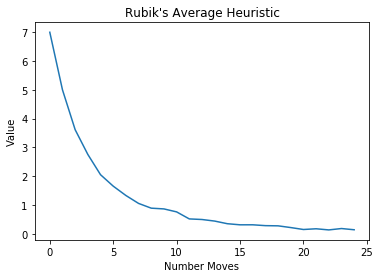

In [4]:
# Examines the average heuristic function values for a cube scrambled by 
# X rotations. Note that values are shifted and scaled before graphing them.

values = [[(162 - fsolver.heuristic(Opticube().scramble(sz=sz))) / 30  for i in range(500)] for sz in range(25)]
averages = np.average(values, axis=1)

plt.figure(2)
plt.plot(averages)
plt.title(f'Rubik\'s Average Heuristic')
plt.ylabel('Value')
plt.xlabel('Number Moves')

print(f"Heuristic value range: [{np.amin(values)}, {np.amax(values)}]")
print(f"Average heruistic value: [{np.amin(averages)}, {np.amax(averages)}]")

In [5]:
class UCTNode:
#{
    UCTFACTOR = math.sqrt(2.0)
    # HEU_SCALE = -5.0 / 105.0
    
    total_visits = 0
    total_nodes = 0
    move_depth = 0
    
    # These for derivation of incremental mean 
    # and standard deviation of heuristic values
    mu_h = 0
    sn_h = 0
    sigma_h = 0
    n = 0
        
    @classmethod
    def update_sigma(cls, heuristic):
    #{
        cls.n += 1
        mu_prev = cls.mu_h
        sn_prev = cls.sn_h
        
        cls.mu_h = mu_prev + ((heuristic - mu_prev) / cls.n)
        cls.sn_h = sn_prev + ((heuristic - mu_prev) * (heuristic - cls.mu_h))
        cls.sigma_h = math.sqrt(cls.sn_h/cls.n)
    #}

    @classmethod
    def reset_tree(cls):
    #{
        cls.total_visits = 0
        cls.total_nodes = 0
        cls.move_depth = 0
    #}
        
    def __init__(self, heuristic, move=None, parent=None):
    #{
        # Move that produces this node/cube state
        self.move = move
                
        # Note: heuristic will be in [-48, 224], thus a
        # scaling factor applied to map to ~(0.0, 7.0]
        self.heuristic = (162 - heuristic) / 30.0
        UCTNode.update_sigma(self.heuristic)
        
#         self.rubistic = None 
        self.numb_visits = 0
        self.child_nodes = []
        self.parent_node = parent
        
        UCTNode.total_nodes += 1
    #}
    
    def __repr__(self):
        return (f"Move:    {self.move}\n"
                f"Visits:  {self.numb_visits}\n"
                f"Value:   {self.value()})")
    
    def set_root(self):
        self.move = None
        self.parent_node = None
        return self
        
    def ucbonus(self):
    #{
        # Calc uncertainty bonus
        exploit = (1 + self.numb_visits)
        explore = np.log(self.parent_node.numb_visits)
        return UCTNode.UCTFACTOR * math.sqrt(explore/exploit)
    #}
    
    def value(self): return self.heuristic
#         if self.rubistic is None: return self.heuristic

    def select_uct_child(self):
        return max(self.child_nodes, key=lambda cld: cld.value() + cld.ucbonus())
    
    def get_uct_children(self):
        return sorted(self.child_nodes, key=lambda cld: cld.value() + cld.ucbonus())
    
    def select_mvp_child(self, mvp=None, depth=0):
    #{
        depth += 1 # Depth here is just for algorithm diagnosics 
        if depth > UCTNode.move_depth: UCTNode.move_depth = depth

        for child in self.child_nodes: mvp = child.select_mvp_child(mvp, depth)
        if (mvp is None) or (self.value() > mvp.value()): mvp = self
        return mvp
    #}
    
    def add_child(self, heuristic, move):
    #{
        child = UCTNode(heuristic, move=move, parent=self)
        self.child_nodes.append(child)
        return child
    #}
    
    def update(self):
        self.numb_visits += 1
        UCTNode.total_visits += 1
#}

In [6]:
class SolveState:
#{
    state_queue = ['Cross', 'FLa', 'FLb', 'FLc', 'FL', 'F2La', 'F2Lb', 'F2Lc', 'F2L', 'Done', 'OLL', 'PLL']
    
    def __init__(self, fsolver):
    #{
        self.fsolver = fsolver
        self.state = SolveState.state_queue[0]
      
        self.complete = {'Cross': -8,
                         'FLa': -11, 'FLb': -14, 'FLc': -17, 'FL': -20,
                         'F2La': -22, 'F2Lb': -24, 'F2Lc': -26, 'F2L': -28, 
                         'OLL': -36, 'PLL': -48}
        
        self.depth_limit = {'Cross': 10,
                            'FLa': 10, 'FLb': 10, 'FLc': 10, 'FL': 10,
                            'F2La': 8, 'F2Lb': 8, 'F2Lc': 8, 'F2L': 8,
                            'OLL': 12, 'PLL': 12}
    #}
    
    def increment_state(self):
        idx = next(i for i, state in enumerate(SolveState.state_queue) if self.state == state)
        self.state = self.state_queue[idx+1]
        return self.state
    
    def is_complete(self, heuristic_value):
        return self.complete[self.state] == heuristic_value
    
    def max_depth(self):
        return self.depth_limit[self.state]
    
    def flet_index(self):
    #{
        flet_idx = None
        if self.state == 'Cross': flet_idx = Opticube._whtcrossindex
        elif self.state == 'FLa': flet_idx = Opticube._tla_index
        elif self.state == 'FLb': flet_idx = Opticube._tlb_index
        elif self.state == 'FLc': flet_idx = Opticube._tlc_index
        elif self.state == 'FL':  flet_idx = Opticube._tlayerindex
        elif self.state == 'F2L': flet_idx = Opticube._t2l_index
        elif self.state == 'OLL': flet_idx = Opticube._oll_index
        else:                     flet_idx = Opticube._movableindex
            
        return flet_idx
    #}
    
    def heuristic(self, opticube):
        return self.fsolver.heuristic_idx(opticube, self.flet_index())
    
    def expand_moves(self, opticube):
        return self.fsolver.restricted_moves(opticube, self.flet_index())
#}

In [12]:
import random, re, time
from IPython.display import clear_output

class TreeSolver:
#{
    ref_moves = None
    prnt_time = time.time()
    
    @staticmethod
    def output_status(node_path_list):
    #{
        if (time.time() - TreeSolver.prnt_time) > 1.0:
        #{            
            output_string = ''
            for depth, node in enumerate(node_path_list):
            #{
                curr_move_str = FaceletSolver.path_str([node.move]) if node.move else 'root'
                reference_move = TreeSolver.ref_moves[depth] if depth < len(TreeSolver.ref_moves) else []

                move_options, found, index = '[', False, -1
                for idx, child in enumerate(node.get_uct_children()):
                #{
                    if reference_move: found = (reference_move == child.move)
                    if idx < 5: move_options += f'{FaceletSolver.path_str([child.move])}:{child.ucbonus()}/{child.value()}, '
                    if found: index = idx; break
                #}
                
                move_options = re.sub(r', $', ']', move_options)
                ref_move_str = FaceletSolver.path_str([reference_move]) if reference_move else 'past'
                if not found: output_string += (f'[{curr_move_str}]: {ref_move_str}, NOT found in {len(node.child_nodes)} moves: {move_options}\n')
                else: output_string += (f'[{curr_move_str}]: {ref_move_str}, found at {index} of {len(node.child_nodes)}: {move_options}\n')
            #}
            
            clear_output(wait=True)
            print(output_string)
            TreeSolver.prnt_time = time.time()
        #}
    #}
    
    @staticmethod
    def output_state_progress(solved, solve_state, opticube, moves):
    #{
        print(f"\nSolved state \'{solve_state.state}\': {solved}")
        print(f"  Numb moves to best node: {len(moves)}, moves: {moves}\n")

        view = CubeView(opticube)
        for depth, mv in enumerate(moves):
        #{
            opticube.rotate(mv)
            if((len(moves) - depth+1) < 20):
                value = solve_state.heuristic(opticube)
                view.push_snapshot(caption=f"{color_name(mv[0])} ({mv[1]}) : {value}")
        #}

        if len(moves): view.draw_snapshops()
        return opticube
    #}
    
    @staticmethod
    def state_tree_search(fsolver, opticube):
    #{
        solve_state = SolveState(fsolver)
        rootnode = UCTNode(solve_state.heuristic(opticube))
        solved, node = TreeSolver.uc_tree_search(opticube, rootnode, solve_state)
        moves = TreeSolver.get_move_sequence(node)
    
        opticube = TreeSolver.output_state_progress(solved, solve_state, opticube, moves)
        
        while solved and (solve_state.increment_state() != 'Done'):
        #{
            solved, node = TreeSolver.uc_tree_search(opticube, node.set_root(), solve_state)
            state_moves = TreeSolver.get_move_sequence(node)
            moves.extend(state_moves)
            
            opticube = TreeSolver.output_state_progress(solved, solve_state, opticube, state_moves)
        #}
        
        if not solved: print("Maximum depth searched:", UCTNode.move_depth)
        return solved, moves, solve_state 
    #}
    
    @staticmethod
    def is_redundant_move(node, move):
        # Aka: is-back-to-back-rotation-of-same-side
        return node.move and (node.move[0] == move[0])

    @staticmethod
    def uc_tree_search(opticube, rootnode, solve_state, max_moves=100, iterations=50000):
    #{
#         # Init CFOP speedcuber algorithm
#         TreeSolver._update_cfop(rootnode)

        # Catches anomoly of uc_tree_search called on already stage-solved cube
        if solve_state.is_complete(solve_state.heuristic(opticube)): return True, rootnode
    
        # UCT loop (w/o MC rollout)
        for i in range(iterations):
        #{
            node = rootnode
            cube = Opticube(opticube)
            UCTNode.move_depth = 0
            
            # SELECT (down to a leaf node on frontier)
            node_path_debug = [node]
            while node.child_nodes:
                node = node.select_uct_child()
                cube.rotate(node.move)
                UCTNode.move_depth += 1
                node_path_debug.append(node)
            
            # Print algorithm status
            # TreeSolver.output_status(node_path_debug)
            
            # EXPAND (adds some subset of the 18 possible rotations)
            if UCTNode.move_depth < solve_state.max_depth():
            #{                
                for move in solve_state.expand_moves(cube):
                #{
                    if not TreeSolver.is_redundant_move(node, move):
                        heuristic = solve_state.heuristic(Opticube(cube).rotate(move))
                        child_node = node.add_child(heuristic, move)
                        if solve_state.is_complete(heuristic):
                            return True, child_node
                #}

                # Descend (one step, no real ROLLOUT)
                node = random.choice(node.child_nodes)
            #}
            
            # BACKTRACK
            while node:
                node.update()
                node = node.parent_node
        #}
        
        return False, rootnode.select_mvp_child()
    #}
    
    @staticmethod
    def get_move_sequence(leaf_node):
    #{
        moves = []
        while leaf_node:
        #{
            if leaf_node.move: moves.append(leaf_node.move)
            leaf_node = leaf_node.parent_node
        #}  
        
        moves.reverse()
        return moves
    #}
#}

Starting heuristic: 162
Inverted scramble moves: [(1, 90), (5, -90), (1, -90), (6, 180), (5, 90), (2, -90), (4, 90), (1, 180), (2, 90), (1, -90), (3, 180), (3, -90), (3, -90), (1, 90), (6, 90), (6, -90), (1, 90), (3, -90), (6, 90), (2, 90)]


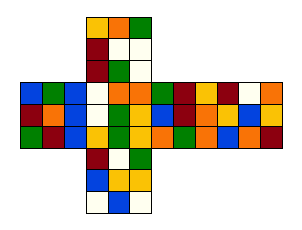

In [13]:
opticube = Opticube()
moves, invmoves = opticube.trace_scramble(sz=20, apply_moves=True)
TreeSolver.ref_moves = invmoves
# TreeSolver.reset_tree()
print("Starting heuristic:", fsolver.heuristic(opticube))
print("Inverted scramble moves:", TreeSolver.ref_moves)
CubeView(opticube).draw_projection()


Solved state 'Cross': True
  Numb moves to best node: 5, moves: [(5, 90), (2, 90), (3, 180), (6, -90), (5, 180)]



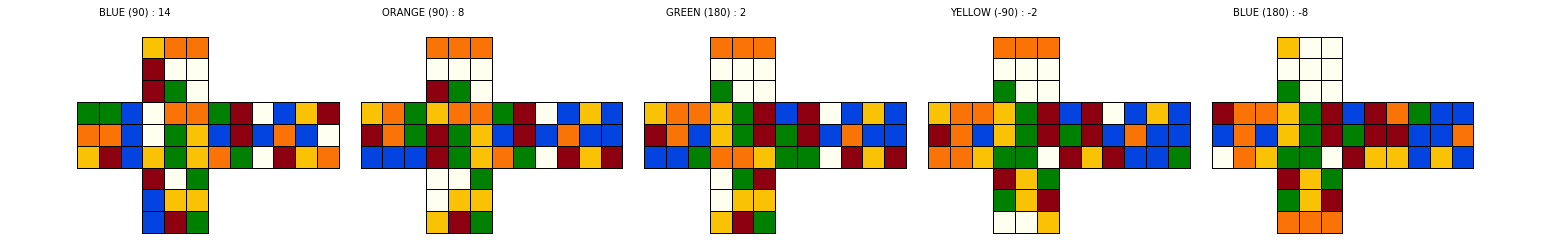


Solved state 'FLa': True
  Numb moves to best node: 4, moves: [(3, 180), (4, 180), (3, 180), (4, 180)]



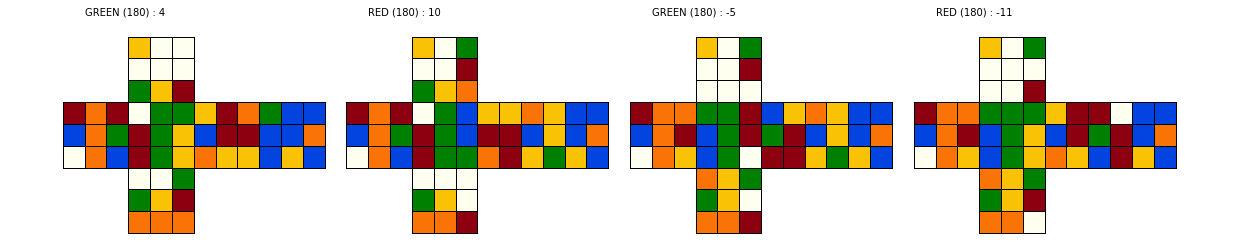


Solved state 'FLb': True
  Numb moves to best node: 6, moves: [(4, 90), (1, 90), (5, -90), (1, -90), (6, -90), (4, -90)]



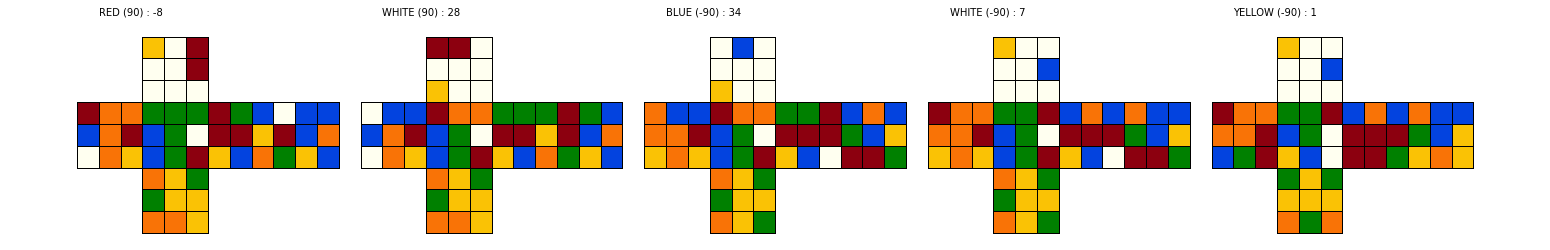

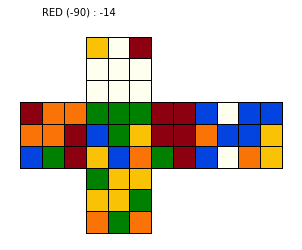


Solved state 'FLc': True
  Numb moves to best node: 6, moves: [(5, -90), (6, 180), (5, 90), (4, -90), (6, 180), (4, 90)]



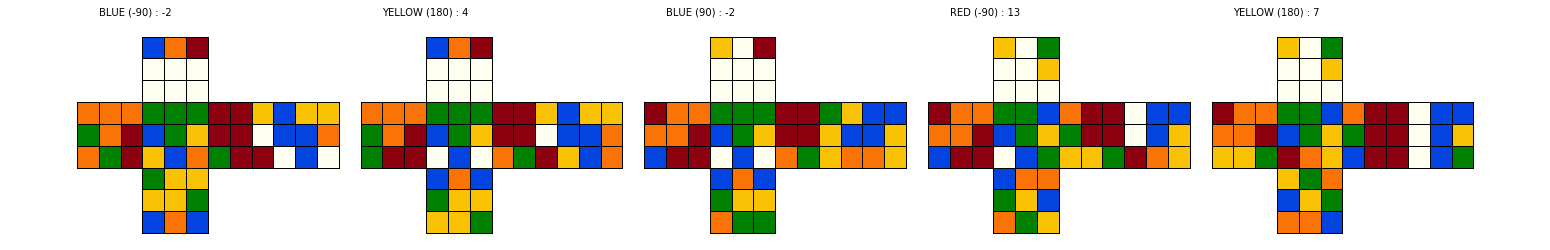

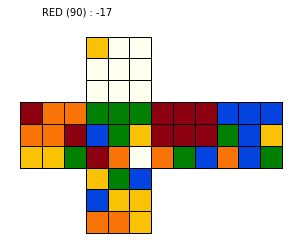


Solved state 'FL': True
  Numb moves to best node: 3, moves: [(2, -90), (6, 180), (2, 90)]



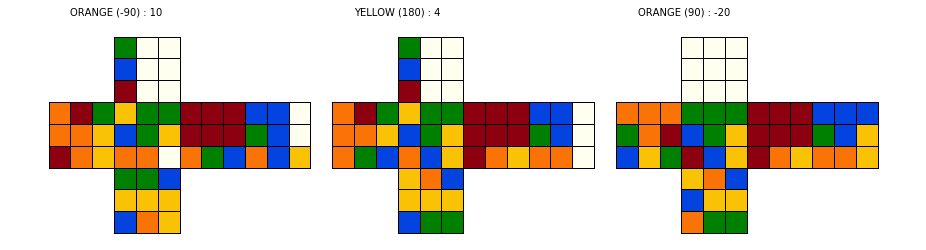


Solved state 'F2La': False
  Numb moves to best node: 0, moves: []

Maximum depth searched: 9


In [14]:
# rootnode = UCTNode(fsolver.heuristic(opticube))
# solved, node = TreeSolver.uc_tree_search(fsolver, opticube, rootnode)
# moves = TreeSolver.get_move_sequence(node)

solved, moves, solve_state = TreeSolver.state_tree_search(fsolver, opticube)

In [ ]:
print("Control solution:\n(scrambled state)")
control_cube = Opticube(opticube)
view = OpticubeView(control_cube)
view.draw_projection()

for inv in invmoves:
    value = -fsolver.heuristic(control_cube.rotate(inv))
    view.push_snapshot(caption=f"{color_name(inv[0])} ({inv[1]}) : {value}")
    
view.draw_snapshops()

print("\nSolved cube:", solved)
print(f"  Numb moves to best node: {len(moves)}\n"
#       f"  Root node value:   {rootnode.value()}\n"
#       f"  Best node value:   {node.value()}\n"
      f"  Total tree nodes:  {UCTNode.total_nodes}\n"
      f"  Total tree depth:  {UCTNode.move_depth}\n"
      f"  Total node visits: {UCTNode.total_visits}\n"
      f"  Value mean:        {UCTNode.mu_h}\n"
      f"  Value std-dev:     {UCTNode.sigma_h}\n"
      f"  Value CFOP state:  {solve_state.state}\n")


solve_cube = Opticube(opticube)
view = OpticubeView(solve_cube)
for depth, mv in enumerate(moves):
#{
    solve_cube.rotate(mv)
    if((len(moves) - depth+1) < 20):
        value = -fsolver.heuristic(solve_cube)
        view.push_snapshot(caption=f"{color_name(mv[0])} ({mv[1]}) : {value}")
#}

view.draw_snapshops()

In [ ]:
# Exploring use of brute force rubistic calculations

# h_vals = np.zeros((10,25))
# r_vals = np.zeros((10,25))

# for i in range(2):
# #{
#     print("iteration:", i)
#     for sz in range(25):
#     #{
#         hr_cube = Opticube().scramble(sz=sz)
#         h_vals[i,sz] = fsolver.heuristic(hr_cube)
#         r_vals[i,sz] = fsolver.rubistic(hr_cube)
#     #}
# #}

# h_avg = np.average(h_vals, axis=0)
# r_avg = np.average(r_vals, axis=0)

# plt.figure(1)
# plt.plot(r_avg - h_avg)
# plt.title(f'Rubik\'s Heuristic/Rubistic')
# plt.ylabel('Values')
# plt.xlabel('Number Moves')

In [ ]:
# Implementations of brute force search tactic, these belong in TreeSolver

#     @staticmethod
#     def brute_heuristic(fsolver, opticube, rootnode, seach_depth, max_depth=30):
#     #{
#         node = rootnode
#         cube = Opticube(opticube)
        
#         if node.value() == 7: return True, node
        
#         # SEARCH subtree for max heuristic
#         node = TreeSolver._search(fsolver, node, opticube, search_depth, max_depth)
        
#         if UCTNode.move_depth < max_depth:
#         #{                
#             for move in Opticube.MOVES:
#             #{
#                 if (node.parent_node is None) or (node.parent_node.move != move):
#                     heuristic = fsolver.heuristic(Opticube(cube).rotate(move))
#                     child_node = node.add_child(heuristic, move)
#                     if heuristic == -48: return True, child_node
#             #}

#             # Descend (one step, no real ROLLOUT)
#             node = random.choice(node.child_nodes)
#         #}
        
#     #}

#     @staticmethod
#     def _search(fsolver, node, cube, search_depth, max_depth):
#     #{
#         # Recursive brute force subtree search
#         if search_depth == 0: return node
        
#         # EXPAND if necessary
#         if (UCTNode.move_depth < max_depth) and (not node.child_nodes):
#         #{
#             UCTNode.move_depth += 1
#             for move in Opticube.MOVES:
#             #{
#                 if (node.parent_node is None) or (node.parent_node.move != move):
#                     node.add_child(fsolver.heuristic(Opticube(cube).rotate(move)), move)
#             #}
#         #}
        
#         best_node = node
#         max_value = -224
        
#         # Brute SEARCH recursion loop
#         for child in node.child_nodes:
#         #{
#             value = TreeSolver._search(child, search_depth-1)
#             if max_value < value:
#                 max_value = value
#                 best_node = child
#         #}      
        
#         return best_node
#     #}

In [ ]:
#     @staticmethod
#     def _update_cfop(rootnode, node=None):
#     #{
#         if not TreeSolver.cfop_mode:
#             TreeSolver.cfop_mode = 'Cross'
#             TreeSolver.root = rootnode
#             return False, rootnode
        
#         elif TreeSolver.cfop_mode == 'Cross':
#             TreeSolver.cfop_mode = 'F2L'
#             TreeSolver.leaf = node.parent_node
#             return False, node.set_root()
        
# #         elif TreeSolver.cfop_mode == 'F2L':
# #             TreeSolver.cfop_mode = None
# #             rootnode.parent_node = TreeSolver.cross
# #             return True, TreeSolver.root
        
#         elif TreeSolver.cfop_mode == 'F2L':
#             TreeSolver.cfop_mode = 'PLL'
#             rootnode.parent_node = TreeSolver.leaf
#             TreeSolver.leaf = node.parent_node
#             return False, node.set_root()
            
#         elif TreeSolver.cfop_mode == 'PLL':
#             TreeSolver.cfop_mode = None
#             rootnode.parent_node = TreeSolver.leaf
#             return True, TreeSolver.root
#     #}

In [ ]:
# import random, re, time
# from IPython.display import clear_output

# class TreeSolver:
# #{
#     ref_moves = None
#     prnt_time = time.time()

#     @staticmethod
#     def output_status(node_path_list):
#     #{
#         if (time.time() - TreeSolver.prnt_time) > 1.0:
#         #{            
#             output_string = ''
#             for depth, node in enumerate(node_path_list):
#             #{
#                 curr_move_str = FaceletSolver.path_str([node.move]) if node.move else 'root'
#                 reference_move = TreeSolver.ref_moves[depth] if depth < len(TreeSolver.ref_moves) else []

#                 move_options, found, index = '[', False, -1
#                 for idx, child in enumerate(node.get_uct_children()):
#                 #{
#                     if reference_move: found = (reference_move == child.move)
#                     if idx < 5: move_options += f'{FaceletSolver.path_str([child.move])}:{child.ucbonus()}/{child.value()}, '
#                     if found: index = idx; break
#                 #}
                
#                 move_options = re.sub(r', $', ']', move_options)
#                 ref_move_str = FaceletSolver.path_str([reference_move]) if reference_move else 'past'
#                 if not found: output_string += (f'[{curr_move_str}]: {ref_move_str}, NOT found in {len(node.child_nodes)} moves: {move_options}\n')
#                 else: output_string += (f'[{curr_move_str}]: {ref_move_str}, found at {index} of {len(node.child_nodes)}: {move_options}\n')
#             #}
            
#             clear_output(wait=True)
#             print(output_string)
#             TreeSolver.prnt_time = time.time()
#         #}
#     #}

#     @staticmethod
#     def uc_tree_search(fsolver, opticube, rootnode, max_moves=30, iterations=10000):
#     #{    
#         # UCT loop (w/no MC rollout)
#         for i in range(iterations):
#         #{
#             node = rootnode
#             cube = Opticube(opticube)
#             UCTNode.move_depth = 0
            
#             # SELECT (down to a leaf node on frontier)
#             node_path_debug = [node]
#             while node.child_nodes:
#                 node = node.select_uct_child()
#                 cube.rotate(node.move)
#                 UCTNode.move_depth += 1
#                 node_path_debug.append(node)
            
#             # Print algorithm status
#             TreeSolver.output_status(node_path_debug)
            
#             # EXPAND (adds some subset of the 18 possible rotations)
#             if UCTNode.move_depth < max_moves:
#             #{                
#                 for move in Opticube.MOVES:
#                 #{
#                     if (node.parent_node is None) or (node.parent_node.move != move):
#                         heuristic = fsolver.heuristic(Opticube(cube).rotate(move))
#                         child_node = node.add_child(heuristic, move)
#                         if heuristic == -48: return True, child_node
#                 #}

#                 # Descend (one step, no real ROLLOUT)
#                 node = random.choice(node.child_nodes)
#             #}
            
#             # BACKTRACK
#             while node:
#                 node.update()
#                 node = node.parent_node
#         #}
        
#         return False, rootnode.select_mvp_child()
#     #}
    
#     @staticmethod
#     def get_move_sequence(leaf_node):
#     #{
#         moves = []
#         root = None
#         while leaf_node:
#         #{
#             if not leaf_node.move: root = leaf_node 
#             else: moves.append(leaf_node.move)
#             leaf_node = leaf_node.parent_node
#         #}  
        
#         moves.reverse()
#         return moves, root
#     #}
# #}

In [ ]:
opticube = Opticube()
view = OpticubeView(opticube)

moves, invmoves = opticube.trace_scramble(sz=3)

for mv in moves:
    opticube.rotate(mv)
    view.push_snapshot(caption=f"{color_name(mv[0])} ({mv[1]})")
    
view.draw_snapshops()

# sequences = fsolver.create_sequence_hash(wildcard=False)
# best_moves = fsolver.best_end_moves(opticube, sequences)
# print(best_moves)

best_move_seq = fsolver.best_sequence(opticube)
sorted_sequence = sorted(best_move_seq.items(), reverse=True, key=lambda kv: kv[1])

max_votes, numb = 0, 0
for seq in sorted_sequence:
    
    if seq[1] > max_votes:
        if numb > 20: break
        print("Votes:", seq[1])
        max_votes = seq[1]
#     elif seq[1] < max_votes: break
    elif seq[1] < max_votes: max_votes = 0
    print("  ", FaceletSolver.path_str(seq[0]))

    numb += 1

print("")
print(fsolver.best_next_moves(opticube), "\n")

fsolver.print_shortest_paths(opticube, sequences)

In [ ]:
class OpticubeTest:
#{
    @staticmethod
    def moving_average(a, n=10):
    #{
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    #}
    
    @staticmethod
    def extract_acc_loss(history_list):
    #{
        accuracy,loss = [],[]
        for h in history_list:
            accuracy.extend(h.history['acc'])
            loss.extend(h.history['loss'])

        accuracy = OpticubeTest.moving_average(accuracy, n=10)
        loss = OpticubeTest.moving_average(loss, n=10)

        return accuracy, loss
    #}
    
    def run_cube_test(self, model):
    #{
        opticube = Opticube()        
        opticube.scramble()
        opticube_b = Opticube(opticube)
        opticube_c = Opticube(opticube)
        
        solver = OpticubeSolver()
        game = solver.solve_cube(model, opticube)
        print("Running Rubik\'s solve_cube test...")

        for state, action, reward, state_p, solved in game:
        #{
            # Apply the action to the actual cube
            side, angle = Opticube.MOVES[action]
            opticube_b.rotate(move=(side, angle))
        
            transition  = "SOLVED-to-" if opticube_b.is_solved() else "UNSOLVED-to-"
            transition += "SOLVED" if opticube_b.is_solved() else "UNSOLVED"

            print((f"  {color_name(side)}({angle}) : {transition} : "
                   f"reward {reward} : solved {solved}"))
        #}

        print("\n")
        mv_number = 1
        cube_view = OpticubeView(opticube_c)
        cube_view.push_snapshot(caption=f"Initial cube state...")
        for _, action, _, _, _ in game:
        #{        
            # Apply the action to the actual cube
            side, angle = Opticube.MOVES[action]
            opticube_c.rotate(move=(side, angle))
            
            caption  = f"Move {mv_number}: {color_name(side)}({angle})"
            if opticube_c.is_solved(): caption += " : SOLVED!!"
            mv_number += 1
            
            cube_view.push_snapshot(caption=caption)
            if opticube_c.is_solved(): break
        #}

        cube_view.draw_snapshops()
    #}
#}

In [ ]:
#     @staticmethod
#     def contains_move(move_depth, current_move, move_options_debug):
#     #{
#         node_mvstr = FaceletSolver.path_str([current_move]) if current_move else 'None'
#         move_options_debug = sorted(move_options_debug, key=lambda mv_val: mv_val[1])
    
#         string, found, index = '[', False, -1
#         if (move_depth-1) < len(TreeSolver.ref_moves):
#         #{
#             for i in range(len(move_options_debug)):
#             #{
#                 found = (TreeSolver.ref_moves[move_depth-1] == move_options_debug[i][0])
#                 string += f'{FaceletSolver.path_str([move_options_debug[i][0]])}:{move_options_debug[i][1]}, '
#                 if found: index = i; break
#             #}
            
#             if not found:
#                 print(f'Node [{node_mvstr}]: {FaceletSolver.path_str([TreeSolver.ref_moves[move_depth-1]])}, '
#                       f'NOT found at depth {move_depth} of {len(move_options_debug)} moves')
#             else:
#                 string = re.sub(r', $', ']', string)
#                 print(f'Node [{node_mvstr}]: {FaceletSolver.path_str([TreeSolver.ref_moves[move_depth-1]])}, '
#                       f'found at depth {move_depth}, move {index} of {len(move_options_debug)}: {string}')
#         #}
#     #}

In [ ]:
# def moving_average(a, n=10):
# #{
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n
# #}

In [ ]:
#Scramble

opticube = Opticube()
cubeview = OpticubeView(opticube)

x = [(RED, -90), (YELLOW, 90), (ORANGE, 90), (WHITE, -90)]
y = [(BLUE, 90), (YELLOW, 90), (GREEN, -90), (WHITE, -90)]
z = [(RED, -90), (GREEN, -90), (ORANGE, 90), (BLUE, 90)]

[opticube.rotate(move) for i in range(5) for move in x]
[opticube.rotate(move) for i in range(5) for move in y]
[opticube.rotate(move) for i in range(5) for move in z]

draw_cube = Opticube(opticube)

# Solve
white_cross  = [(WHITE, -90), (YELLOW, -90), (GREEN, -90), (RED, 180), (YELLOW, 180), (BLUE, 180)]
top_layer    = [(YELLOW, -90), (ORANGE, -90), (YELLOW, -90), (ORANGE, 90),
                (YELLOW, 90), (GREEN, 90), (YELLOW, -90), (GREEN, -90),
                (RED, -90), (YELLOW, 180), (RED, 90), (YELLOW, 180),
                (GREEN, -90), (YELLOW, 90), (GREEN, 90),
                (BLUE, -90), (YELLOW, -90), (BLUE, 90), (YELLOW, 90),
                (BLUE, -90), (YELLOW, -90), (BLUE, 90)]
second_layer = [(ORANGE,-90), (YELLOW,90), (ORANGE,90), (BLUE,-90), (ORANGE,90), (BLUE,90), (ORANGE,-90),
                (YELLOW,90), (BLUE,-90), (YELLOW,90), (BLUE,90), (RED,90), (BLUE,90), (RED,-90), (BLUE,-90),
                (ORANGE,90), (YELLOW,-90), (ORANGE,-90), (GREEN,-90), (ORANGE,-90), (GREEN,90), (ORANGE,90),
                (GREEN,-90), (YELLOW,-90), (GREEN,90), (RED,-90), (GREEN,90), (RED,90), (GREEN,-90)]

bottom_layer = [(ORANGE,90), (BLUE,90), (YELLOW,90), (BLUE,-90), (YELLOW,-90), (BLUE,90), (YELLOW,90), (BLUE,-90), (YELLOW,-90), (ORANGE,-90), (YELLOW, 180),
                (YELLOW,90), (GREEN,-90), (YELLOW,-90), (BLUE,-90), (YELLOW,90), (GREEN,90), (YELLOW,-90), (BLUE,90),
                (YELLOW,90), (RED,-90), (YELLOW,-90), (ORANGE,-90), (YELLOW,90), (RED,90), (YELLOW,-90), (ORANGE,90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90), (YELLOW,90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90), (YELLOW,90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90),
                (BLUE, -90), (WHITE,90), (BLUE, 90), (WHITE,-90), (YELLOW,180)]

d1, d2, d3, d4 = [opticube.distance()], [0], [0], [0]

cubeview.draw_projection()
for move in white_cross:
    d1.append(opticube.rotate(move).distance())
    d2.append(None)
    d3.append(None)
    d4.append(None)
# cubeview.draw_projection()

d2[-1]=d1[-1]
for move in top_layer:
    d1.append(None)
    d2.append(opticube.rotate(move).distance())
    d3.append(None)
    d4.append(None)
# cubeview.draw_projection()

d3[-1] = d2[-1]
for move in second_layer:
    d1.append(None)
    d2.append(None)
    d3.append(opticube.rotate(move).distance())
    d4.append(None)
# cubeview.draw_projection()

d4[-1] = d3[-1]
for move in bottom_layer:
    d1.append(None)
    d2.append(None)
    d3.append(None)
    d4.append(opticube.rotate(move).distance())
# cubeview.draw_projection()

dists = [draw_cube.distance()]
solve_sequence = white_cross + top_layer + second_layer + bottom_layer
dists.extend([draw_cube.rotate(move).distance() for move in solve_sequence])
# dists = moving_average(dists)


# cubeview = OpticubeView(draw_cube)
# for move in solve_sequence:
#     cubeview.push_snapshot()
#     draw_cube.rotate(move)

# cubeview.draw_snapshops()
    
matplotlib.rcParams['figure.figsize'] = (20, 4)

index = 1
for dseg in [d1,d2,d3,d4]:
#{
    div, conv = [],[]
    converging = None
    
    for i in range(1, len(d1)):
    #{
        if dseg[i-1] is not None and dseg[i] is not None:
            slope = dseg[i] - dseg[i-1]            
            if (converging is None) and (slope < 0):    conv.append(1)
            elif (converging is None) and (slope > 0):  div.append(1)   
            elif converging and (slope < 0):     conv[-1] += 1
            elif not converging and (slope > 0): div[-1] += 1
            elif converging and (slope > 0):     div.append(1)
            elif not converging and (slope < 0): conv.append(1)
            converging = (slope < 0)
    #}
    
#     print(f'Segment {index}: average steps per div: {np.mean(div)}, conv: {np.mean(conv)}')
    print(f'Segment {index}: div: {div}, conv: {conv}')
    index += 1
#}

# Plot 
plt.figure(1)
plt.plot(d1)
plt.plot(d2)
plt.plot(d3)
plt.plot(d4)
plt.axis([-1.0, 136.0, 1.0, 2.5])
plt.title(f'Rubik\'s Solution Heuristic')
plt.ylabel('Distance')
plt.xlabel('Move Number')

# Plot 
plt.figure(2)
plt.plot(dists)
plt.axis([-1.0, 136.0, 1.0, 2.5])
plt.title(f'Rubik\'s Solution Heuristic')
plt.ylabel('Moving Avg Distance')
plt.xlabel('Move Number')

In [ ]:
# class UCTNode:
# #{
#     UCTFACTOR = math.sqrt(2.0)
    
#     total_visits = 0
#     total_nodes = 0

#     @classmethod
#     def reset_tree(cls):    
#         cls.total_visits = 0
#         cls.total_nodes = 0
    
#     def __init__(self, distance=2.25, action=None, parent=None):
#     #{
#         # Action that produced this node/state
#         self.action = action
        
#         self.numb_visits = 0
#         self.child_nodes = []
#         self.parent_node = parent

#         # Value ends up in set (0, 1.25] 
#         self.value = 2.25 - distance
#         self.avg_value = self.value
        
#         UCTNode.total_nodes += 1
#     #}
    
#     def __repr__(self):
#         return (f"Action:  {self.action}\n"
#                 f"Visits:  {self.numb_visits}\n"
#                 f"Value:   {self.value}\n"
#                 f"Avg Val: {self.avg_value})")
    
#     def set_root(self):
#         self.parent_node = None
#         return self
    
#     def ucbonus(self):
#     #{
#         # Calc uncertainty bonus
#         exploit = (1 + self.numb_visits)
#         explore = np.log(self.parent_node.numb_visits)
#         return UCTNode.UCTFACTOR * math.sqrt(explore/exploit)
#     #}
    
#     def select_uct_child(self):
#         return max(self.child_nodes, key=lambda cld: cld.avg_value + cld.ucbonus())
    
#     def select_fav_child(self):
#         return max(self.child_nodes, key=lambda cld: cld.numb_visits)
    
#     def add_child(self, action):
#     #{
#         child = UCTNode(action=action, parent=self)
#         self.child_nodes.append(child)
#         return child
#     #}
    
#     def update(self, distance):
#     #{
#         self.numb_visits += 1
#         self.value += (2.25 - distance)
#         self.avg_value = self.value/self.numb_visits
#         UCTNode.total_visits += 1
#     #}
# #}

In [ ]:
# import keras, random, time
# from keras.models import Model
# from keras.layers import Dense, Input

# class OpticubeSolver:
# #{
#     def __init__(self):
#         self.gamma = 0.95

#     def create_opticube_model(self, summarize=True):
#     #{  
#         # Prime input, connect layers, get ref to output
#         X_input  = Input(shape=(162,))
#         X        = Dense(units=162, activation='relu')(X_input)
#         X        = Dense(units=162, activation='relu')(X)
#         X        = Dense(units=162, activation='relu')(X)
#         Q_output = Dense(units=18, activation='linear')(X)
                
#         # Construct and compile the full-cube model
#         cube_model = Model(inputs=X_input, outputs=Q_output)
#         cube_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        
#         if summarize: cube_model.summary()        
#         return cube_model
#     #}
    
#     def nn_state(self, cube):
#         return cube.state().reshape((1, 162))
    
#     # Plays max of 128 moves/rotations trying to solve the cube
#     def solve_cube(self, model, cube, nmoves=128, training=False):
#     #{        
#         gamememory = []
#         UCTNode.reset_tree()
#         rootnode = UCTNode(cube.distance())
        
#         for mvnum in range(nmoves):
#         #{
#             # Initial state
#             state  = self.nn_state(cube)
            
#             # Determine and apply the best next move
#             vnode = self.uc_tree_search(model, cube, rootnode)
#             solved = cube.rotate(Opticube.MOVES[vnode.action]).is_solved()

#             # Store training information
#             gamememory.append((state, vnode.action, vnode.avg_value, self.nn_state(cube), solved))
            
#             if solved: break
#             else: rootnode = vnode.set_root()
#         #}
        
#         return gamememory
#     #}
    
#     def train_cube_model(self, model, playmemory, batch_size=128):
#     #{
#         if len(playmemory) < batch_size: batch_size = len(playmemory)

#         in_states = np.zeros((batch_size, 162))
#         y_truish  = np.zeros((batch_size, len(Opticube.MOVES)))
#         Qs_solved = np.zeros((batch_size, len(Opticube.MOVES)))
#         minibatch = random.sample(playmemory, batch_size)
        
#         for m in range(batch_size):
#         #{
#             # Unpack play memory
#             state, action, reward, state_p, solved = minibatch[m]
        
#             # Batch of input states 
#             in_states[m] = state
            
#             # Output target batch (r + discounted Rt+1)
#             Qs_p = Qs_solved if solved else model.predict(state_p, batch_size=1)
#             y_truish[m] = model.predict(state, batch_size=1)
#             y_truish[m, action] = reward + (self.gamma * np.amax(Qs_p))            
#         #}
                
#         return model.fit(in_states, y_truish, batch_size=batch_size, epochs=1, verbose=0)
#     #}
    
#     def learn_cube(self, cube_model, episodes=10): #episodes=450
#     #{
#         learning_cube = Opticube()
#         learnmemory, history = [], []
#         initial_times, final_times, tree_stats = [],[],[]
        
#         for j in range(episodes+1):
#         #{
#             initial_times.append(time.time())
        
#             # Reset env and train
#             learning_cube.scramble()                
#             learnmemory.extend(self.solve_cube(cube_model, learning_cube, training=True))
#             history.append(self.train_cube_model(cube_model, learnmemory))
            
#             final_times.append(time.time())
#             tree_stats.append(UCTNode.total_visits)
            
# #             if (j % 2000) == 0:
#             if (j % 2) == 0:
#                 tree = np.mean(tree_stats)
#                 duration = np.mean(np.array(final_times) - np.array(initial_times))
#                 print(f" Training Opticube: episode {j} of {episodes}")
#                 print(f"   Average episode duration: {duration} sec")
#                 print(f"   Average tree nodes: {tree[0]}, visits: {tree[1]}")
#                 initial_times, final_times, tree_stats = [],[],[]
#         #}
        
#         return history
#     #}
    
#     def uc_tree_search(self, model, opticube, rootnode, iterations=1000):
#     #{
#         # UCT loop (w/no MC rollout)
#         for i in range(iterations):
#         #{            
#             node = rootnode
#             cube = Opticube(opticube)
            
#             # Select (down to leaf)
#             while node.child_nodes:
#                 node = node.select_uct_child()
#                 cube.rotate(Opticube.MOVES[node.action])
                
#             # Expand fully and evaluate via NN
#             for action in range(len(Opticube.MOVES)): node.add_child(action)
#             action = np.argmax(model.predict(self.nn_state(cube), batch_size=1))
#             dist = cube.rotate(Opticube.MOVES[action]).distance()
#             node = node.child_nodes[action]
            
#             # Backup
#             while node:
#                 node.update(dist)
#                 node = node.parent_node
#         #}
        
#         return rootnode.select_fav_child()
#     #}
    
# #     def uc_tree_search_log(self, model, opticube, rootnode, iterations=1000):
# #     #{
# #         start = time.time()
# #         proto_avg = {'ctor': 0,
# #                      'select': 0,
# #                      'expand': 0,
# #                      'backup': 0}
        
# #         # UCT loop (w/no MC rollout)
# #         for i in range(iterations):
# #         #{
# #             initial = time.time()
            
# #             node = rootnode
# #             cube = Opticube(opticube)
            
# #             ctor = time.time()

# #             # Select (down to leaf)
# #             while node.child_nodes:
# #                 node = node.select_uct_child()
# #                 cube.rotate(Opticube.MOVES[node.action])
                
# #             select = time.time()

# #             # Expand fully and evaluate via NN
# #             for action in range(len(Opticube.MOVES)): node.add_child(action)
# #             action = np.argmax(model.predict(self.nn_state(cube), batch_size=1))
# #             dist = cube.rotate(Opticube.MOVES[action]).distance()
# #             node = node.child_nodes[action]
            
# #             expand = time.time()

# #             # Backup
# #             while node:
# #                 node.update(dist)
# #                 node = node.parent_node
                
# #             backup = time.time()
            
# #             proto_avg['ctor'] += (ctor - initial)
# #             proto_avg['select'] += (select - ctor)
# #             proto_avg['expand'] += (expand - select)
# #             proto_avg['backup'] += (backup - expand)
# #         #}
        
# #         vnode = rootnode.select_fav_child()
        
# #         duration = time.time() - start
# #         a = proto_avg['ctor']  / duration
# #         b = proto_avg['select'] / duration
# #         c = proto_avg['expand'] / duration
# #         d = proto_avg['backup'] / duration
        
# #         print(f"  {iterations} UCT search iterations: {time.time() - start} sec")
# #         print(f"    ctor: {a}, select: {b}, expand: {c}, backup: {d}")
              
# #         return vnode
# #     #}
# #}

In [ ]:
import keras, random, time
from keras.models import Model
from keras.layers import Dense, Input

class SupervisedSolver:
#{
    def __init__(self):
        self.gamma = 0.95

    def create_supervised_model(self, summarize=True):
    #{  
        # Prime input, connect layers, get ref to output
        X_input  = Input(shape=(162,))
        X        = Dense(units=162, activation='relu')(X_input)
        X        = Dense(units=162, activation='relu')(X)
        X        = Dense(units=162, activation='relu')(X)
        X        = Dense(units=162, activation='relu')(X)
        X        = Dense(units=162, activation='relu')(X)
        X        = Dense(units=162, activation='relu')(X)
        X        = Dense(units=162, activation='relu')(X)
        X        = Dense(units=162, activation='relu')(X)
        Q_output = Dense(units=18, activation='softmax')(X)
                
        # Construct and compile the full-cube model
        cube_model = Model(inputs=X_input, outputs=Q_output)
        
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
        early_stop = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
        cube_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
                
        if summarize: cube_model.summary()        
        return cube_model
    #}
    
    def generate_dataset(self, sz_factor=300):
    #{
        invact = [1,-1,0]
        Xl, Yl, Xlv, Ylv = [], [], [], []
        for gn in range(1, GODS_NUMBER+1):
        #{
            for iters in range(int(gn * sz_factor * (np.log(gn)+1))):
            #{
                cube = Opticube()
                if np.random.random() < 0.2:
                    for action in np.random.randint(len(Opticube.MOVES), size=gn):
                        Xlv.append(cube.rotate(Opticube.MOVES[action]).state())
                        Ylv.append(np.zeros((len(Opticube.MOVES),)))
                        Ylv[-1][action + invact[action%3]] = 1.0
                else:
                    for action in np.random.randint(len(Opticube.MOVES), size=gn):
                        Xl.append(cube.rotate(Opticube.MOVES[action]).state())
                        Yl.append(np.zeros((len(Opticube.MOVES),)))
                        Yl[-1][action + invact[action%3]] = 1.0
            #}
        #}
        
        X, Y, Xval, Yval = np.array(Xl), np.array(Yl), np.array(Xlv), np.array(Ylv)
        print((f"Generated dataset:\n X.shape = {X.shape}\n Y.shape = {Y.shape}\n"
               f" Xval.shape = {Xval.shape}\n Yval.shape = {Yval.shape}"))
        return X, Y, Xval, Yval
    #}
    
    # Plays max of 128 moves/rotations trying to solve the cube
    def solve_cube(self, model, cube, nmoves=128, training=False):
    #{        
        gamememory = []
        UCTNode.reset_tree()
        rootnode = UCTNode(cube.distance())
        
        for mvnum in range(nmoves):
        #{
            # Initial state
            state  = self.nn_state(cube)
            
            # Determine and apply the best next move
            vnode = self.uc_tree_search(model, cube, rootnode)
            solved = cube.rotate(Opticube.MOVES[vnode.action]).is_solved()

            # Store training information
            gamememory.append((state, vnode.action, vnode.avg_value, self.nn_state(cube), solved))
            
            if solved: break
            else: rootnode = vnode.set_root()
        #}
        
        return gamememory
    #}
    
    def train_cube_model(self, model, playmemory, batch_size=128):
    #{
        if len(playmemory) < batch_size: batch_size = len(playmemory)

        in_states = np.zeros((batch_size, 162))
        y_truish  = np.zeros((batch_size, len(Opticube.MOVES)))
        Qs_solved = np.zeros((batch_size, len(Opticube.MOVES)))
        minibatch = random.sample(playmemory, batch_size)
        
        for m in range(batch_size):
        #{
            # Unpack play memory
            state, action, reward, state_p, solved = minibatch[m]
        
            # Batch of input states 
            in_states[m] = state
            
            # Output target batch (r + discounted Rt+1)
            Qs_p = Qs_solved if solved else model.predict(state_p, batch_size=1)
            y_truish[m] = model.predict(state, batch_size=1)
            y_truish[m, action] = reward + (self.gamma * np.amax(Qs_p))            
        #}
                
        return model.fit(in_states, y_truish, batch_size=batch_size, epochs=1, verbose=0)
    #}
    
    def learn_cube(self, cube_model, episodes=10): #episodes=450
    #{
        learning_cube = Opticube()
        learnmemory, history = [], []
        initial_times, final_times, tree_stats = [],[],[]
        
        for j in range(episodes+1):
        #{
            initial_times.append(time.time())
        
            # Reset env and train
            learning_cube.scramble()                
            learnmemory.extend(self.solve_cube(cube_model, learning_cube, training=True))
            history.append(self.train_cube_model(cube_model, learnmemory))
            
            final_times.append(time.time())
            tree_stats.append(UCTNode.total_visits)
            
#             if (j % 2000) == 0:
            if (j % 2) == 0:
                tree = np.mean(tree_stats)
                duration = np.mean(np.array(final_times) - np.array(initial_times))
                print(f" Training Opticube: episode {j} of {episodes}")
                print(f"   Average episode duration: {duration} sec")
                print(f"   Average tree nodes: {tree[0]}, visits: {tree[1]}")
                initial_times, final_times, tree_stats = [],[],[]
        #}
        
        return history
    #}
    
    def uc_tree_search(self, model, opticube, rootnode, iterations=1000):
    #{
        # UCT loop (w/no MC rollout)
        for i in range(iterations):
        #{            
            node = rootnode
            cube = Opticube(opticube)
            
            # Select (down to leaf)
            while node.child_nodes:
                node = node.select_uct_child()
                cube.rotate(Opticube.MOVES[node.action])
                
            # Expand fully and evaluate via NN
            for action in range(len(Opticube.MOVES)): node.add_child(action)
            action = np.argmax(model.predict(self.nn_state(cube), batch_size=1))
            dist = cube.rotate(Opticube.MOVES[action]).distance()
            node = node.child_nodes[action]
            
            # Backup
            while node:
                node.update(dist)
                node = node.parent_node
        #}
        
        return rootnode.select_fav_child()
    #}
    
#}

In [ ]:
X, Y, Xval, Yval = SupervisedSolver().generate_dataset()

In [ ]:
supersolver = SupervisedSolver()
policy_model = supersolver.create_supervised_model()
history = policy_model.fit(X, Y, validation_data=(Xval, Yval), batch_size=256, epochs=10)

In [ ]:
# Set up a wider notebook plot display size
#print(matplotlib.rcParams['figure.figsize'])
matplotlib.rcParams['figure.figsize'] = (20, 4)

# List all data in history
print(history.history.keys())

# Plot with respect to accuracy
plt.figure(1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')

# Plot with respect to loss
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')

In [ ]:
#data = SupervisedSolver().generate_dataset()
print(len(data))

minibatch = random.sample(data, 20)
X, actions = zip(*minibatch)

Y = np.zeros((20, len(Opticube.MOVES)))
Y[np.arange(20), np.array(actions)] = 1.0

print(np.array(actions))
print(Y)
print(np.array(X))

index = 1
solveseq = []
cube = Opticube()
view = OpticubeView(cube)
# for state, invact in data[70000]:
for state, invact in minibatch:

    cube.reset(state=state)
    view.push_snapshot(caption=f"Move {index}")
    solveseq.append(invact)
    index +=1

view.draw_snapshops()    
# view = OpticubeView(cube)

# index = 1
# dist = []
# print("Solution")
# for action in reversed(solveseq):
#     dist.append(cube.distance())
#     cube.rotate(Opticube.MOVES[action])
#     view.push_snapshot(caption=f"Move {index}, dist: {cube.distance()}")
#     index +=1

# view.draw_snapshops()
    
# # Plot 
# plt.figure(2)
# plt.plot(dist)
# plt.axis([-1, 21, 1.0, 2.5])
# plt.title(f'Rubik\'s Solution Heuristic')
# plt.ylabel('Moving Avg Distance')
# plt.xlabel('Move Number')

# [int(gn * 1 * (np.log(gn)+1)) for gn in range(1, GODS_NUMBER+1)]

In [ ]:
from decimal import Decimal

print('%.2E' % Decimal(f'{sum([np.power(18,n) for n in range(21)])}'))
print('%.2E' % Decimal('43252003274489856000'))


In [ ]:
# class OpticubeTest:
# #{
#     @staticmethod
#     def moving_average(a, n=10):
#     #{
#         ret = np.cumsum(a, dtype=float)
#         ret[n:] = ret[n:] - ret[:-n]
#         return ret[n - 1:] / n
#     #}
    
#     @staticmethod
#     def extract_acc_loss(history_list):
#     #{
#         accuracy,loss = [],[]
#         for h in history_list:
#             accuracy.extend(h.history['acc'])
#             loss.extend(h.history['loss'])

#         accuracy = OpticubeTest.moving_average(accuracy, n=10)
#         loss = OpticubeTest.moving_average(loss, n=10)

#         return accuracy, loss
#     #}
    
#     def run_cube_test(self, model):
#     #{
#         opticube = Opticube()        
#         opticube.scramble()
#         opticube_b = Opticube(opticube)
#         opticube_c = Opticube(opticube)
        
#         solver = OpticubeSolver()
#         game = solver.solve_cube(model, opticube)
#         print("Running Rubik\'s solve_cube test...")

#         for state, action, reward, state_p, solved in game:
#         #{
#             # Apply the action to the actual cube
#             side, angle = Opticube.MOVES[action]
#             opticube_b.rotate(move=(side, angle))
        
#             transition  = "SOLVED-to-" if opticube_b.is_solved() else "UNSOLVED-to-"
#             transition += "SOLVED" if opticube_b.is_solved() else "UNSOLVED"

#             print((f"  {color_name(side)}({angle}) : {transition} : "
#                    f"reward {reward} : solved {solved}"))
#         #}

#         print("\n")
#         mv_number = 1
#         cube_view = OpticubeView(opticube_c)
#         cube_view.push_snapshot(caption=f"Initial cube state...")
#         for _, action, _, _, _ in game:
#         #{        
#             # Apply the action to the actual cube
#             side, angle = Opticube.MOVES[action]
#             opticube_c.rotate(move=(side, angle))
            
#             caption  = f"Move {mv_number}: {color_name(side)}({angle})"
#             if opticube_c.is_solved(): caption += " : SOLVED!!"
#             mv_number += 1
            
#             cube_view.push_snapshot(caption=caption)
#             if opticube_c.is_solved(): break
#         #}

#         cube_view.draw_snapshops()
#     #}
# #}

In [ ]:
solver = OpticubeSolver()
model = solver.create_opticube_model()

In [ ]:
history = solver.learn_cube(model)

In [ ]:
accuracy, loss = OpticubeTest.extract_acc_loss(history)

print(accuracy)
print(loss)

# Set up a wider notebook plot display size
#print(matplotlib.rcParams['figure.figsize'])
matplotlib.rcParams['figure.figsize'] = (20, 4)

# Plot with respect to accuracy
plt.figure(1)
plt.plot(accuracy)
plt.title(f'Rubik\'s Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Episode')

# Plot with respect to loss
plt.figure(2)
plt.plot(loss)
plt.title(f'Rubik\'s Model Loss')
plt.ylabel('Loss')
plt.xlabel('Episode')